In [54]:
import numpy as np
from numpy import fft
from math import pi
import matplotlib.pyplot as plt

In [55]:
N = 8
rank = 0
Np = 8

kn = N//2 + 1

kx = fft.fftfreq(N, 1./N)
ky = kx[rank*Np:(rank+1)*Np].copy()
kz = kx[:(N//2+1)].copy()
kz[-1] *= -1

#(3, N, Np, Np)
K = np.array(np.meshgrid(kx, ky, kz, indexing='ij'), dtype=int)

X = np.mgrid[rank*Np:(rank+1)*Np, :N, :N].astype(float)*2*pi/N

In [56]:
print(kx.shape)
print(ky.shape)
print(kz.shape)
K;

(8,)
(8,)
(5,)


In [68]:
np.max(X[0])

5.497787143782138

In [57]:
def fftn_single(u, fu):
    fu[:] = fft.rfftn (u , axes =( 0 ,1 , 2 ) )

def ifftn_single(fu, u):
    u[:] = fft.irfftn ( fu , axes =( 0 ,1 , 2 ) )

In [58]:
u = np.sin(X[0])
uback = np.zeros((N, N, N))
uhat = np.zeros((N, N, kn), dtype = complex)

In [59]:
fftn_single(u, uhat);
ifftn_single(uhat, uback);

print(uhat.sum())
print(uhat.shape)

0j
(8, 8, 5)


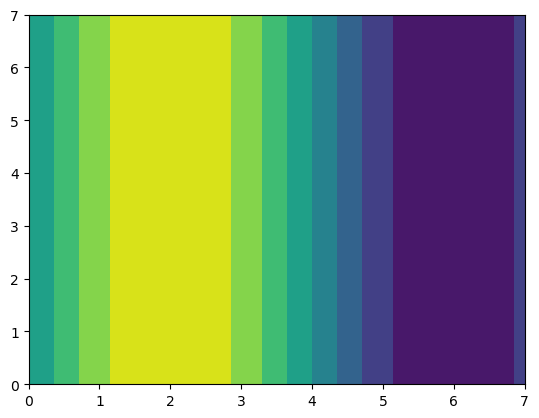

In [64]:
plt.contourf(u[:, :, 0].transpose())

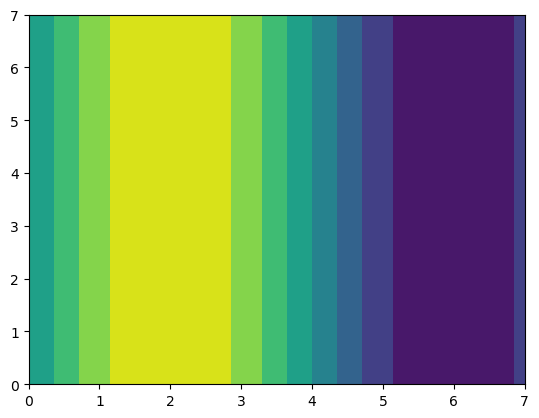

In [67]:
plt.contourf(uback[:, :, 0].transpose())